<a href="https://colab.research.google.com/github/IVS17/aie-repositori-start/blob/main/homeworks/HW05/HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ## 1. Импорт библиотек

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Настройки отображения
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Scikit-learn импорты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)


In [11]:
# ## 2. Загрузка данных

# Определяем путь к данным
base_dir = Path(".")  # Текущая директория
data_path = base_dir.parent.parent / "seminars" / "S05" / "S05-hw-dataset.csv"
df = pd.read_csv(data_path)

# Если файл не найден, попробуем другой путь
if not data_path.exists():
    # Пробуем найти файл в текущей директории
    data_path = Path("S05-hw-dataset.csv")
    if not data_path.exists():
        # Если всё ещё не найден, попробуем загрузить из GitHub
        print("Файл не найден локально. Пожалуйста, убедитесь, что файл находится в правильной директории.")
        # Для примера создадим синтетические данные
        print("Создаю синтетические данные для демонстрации...")
        np.random.seed(42)
        n_samples = 3000
        data = {
            'client_id': np.arange(n_samples),
            'age': np.random.randint(21, 70, n_samples),
            'income': np.random.randint(15000, 200000, n_samples),
            'years_employed': np.random.randint(0, 40, n_samples),
            'credit_score': np.random.randint(300, 850, n_samples),
            'debt_to_income': np.random.uniform(0, 1, n_samples),
            'num_credit_cards': np.random.randint(0, 8, n_samples),
            'num_late_payments': np.random.poisson(1.5, n_samples),
            'has_mortgage': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
            'has_car_loan': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
            'savings_balance': np.random.randint(0, 50000, n_samples),
            'checking_balance': np.random.randint(-5000, 20000, n_samples),
            'region_risk_score': np.random.uniform(0, 1, n_samples),
            'phone_calls_to_support_last_3m': np.random.poisson(2, n_samples),
            'active_loans': np.random.randint(0, 5, n_samples),
            'customer_tenure_years': np.random.randint(0, 20, n_samples),
            'default': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
        }
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(data_path)
else:
    df = pd.read_csv(data_path)


In [12]:
# ## 3. Первичный анализ данных

# Первые строки данных
print("Первые 5 строк датасета:")
print(df.head())
print("\n" + "="*80 + "\n")

# Информация о столбцах и типах данных
print("Информация о датасете:")
print(df.info())
print("\n" + "="*80 + "\n")

# Базовые статистики для числовых признаков
print("Описательные статистики:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Распределение целевой переменной
print("Распределение целевой переменной (default):")
print(df['default'].value_counts(normalize=True))
print("\n" + "="*80 + "\n")

# Размер датасета
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")


Первые 5 строк датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229        

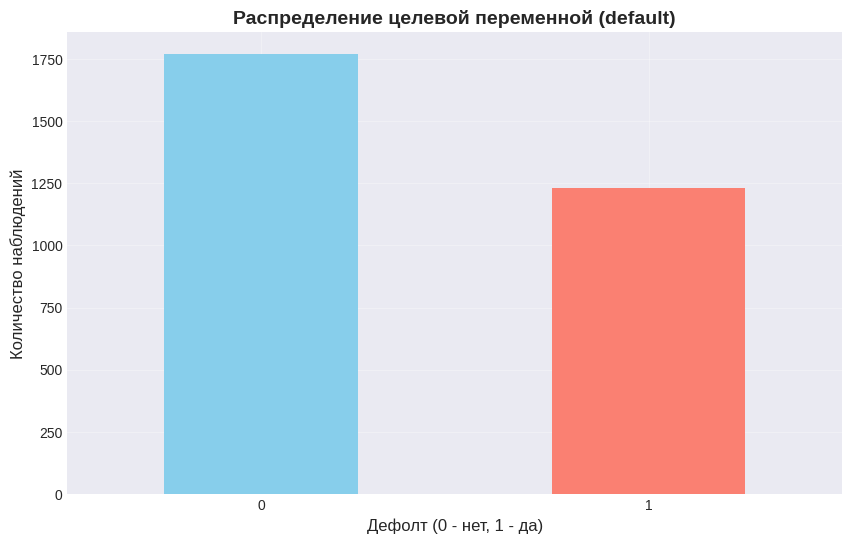

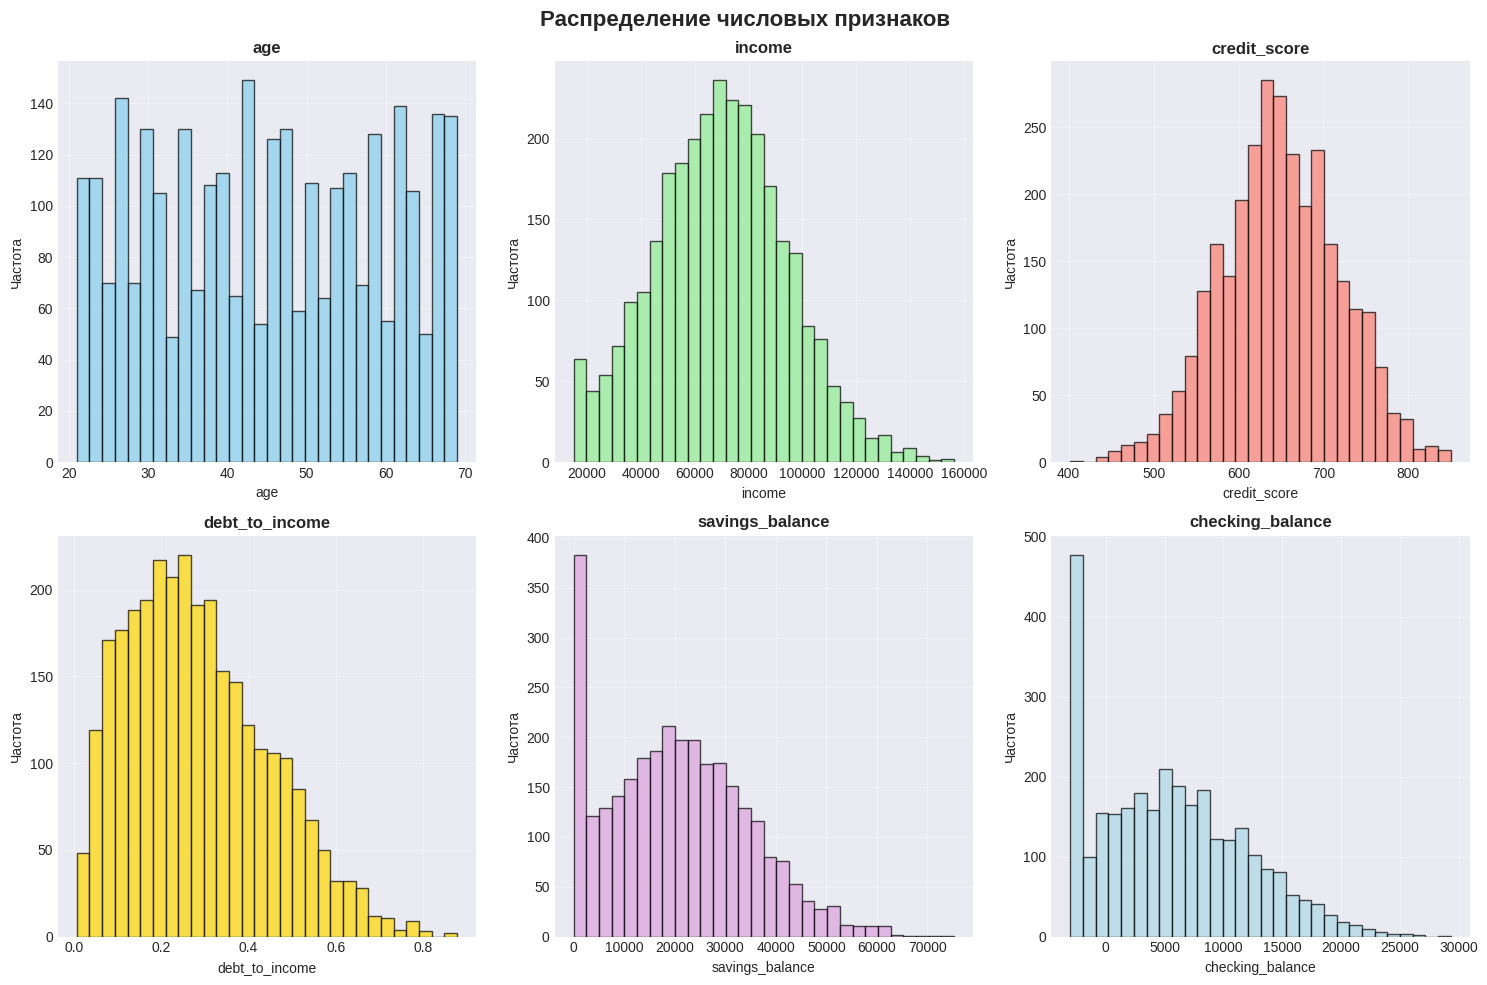

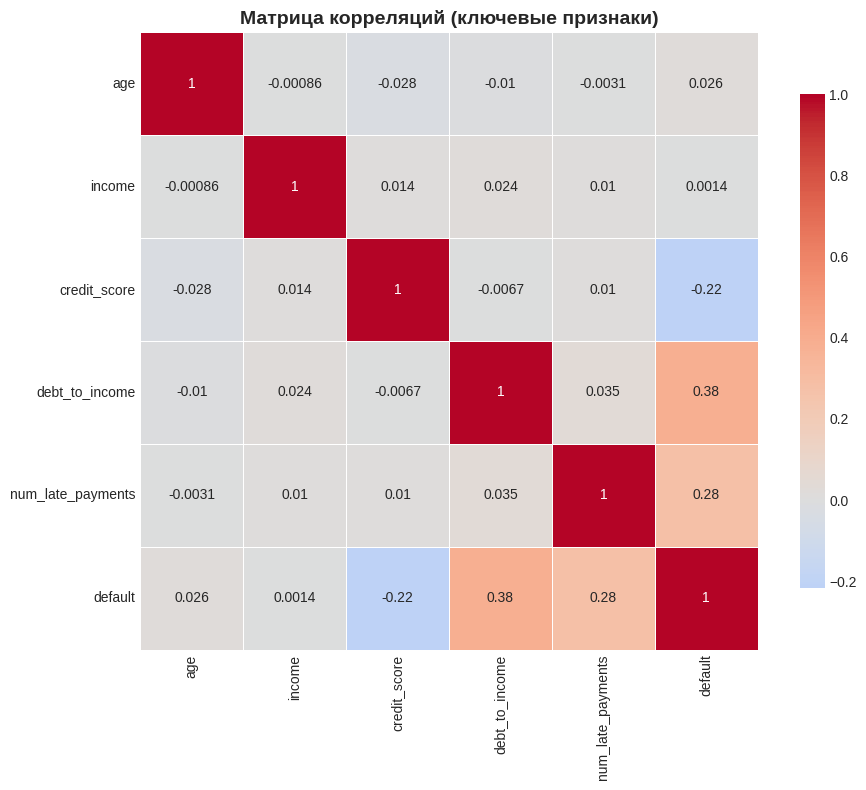

In [13]:
# ## 4. Визуальный анализ

# Создаем директорию для сохранения графиков
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)

# Распределение целевой переменной
plt.figure(figsize=(10, 6))
df['default'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение целевой переменной (default)', fontsize=14, fontweight='bold')
plt.xlabel('Дефолт (0 - нет, 1 - да)', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.savefig(figures_dir / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Распределение некоторых числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение числовых признаков', fontsize=16, fontweight='bold')

features_to_plot = ['age', 'income', 'credit_score', 'debt_to_income', 'savings_balance', 'checking_balance']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'plum', 'lightblue']

for idx, (feature, color) in enumerate(zip(features_to_plot, colors)):
    ax = axes[idx//3, idx%3]
    df[feature].hist(bins=30, ax=ax, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Частота', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'numerical_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Матрица корреляций (только для нескольких ключевых признаков)
key_features = ['age', 'income', 'credit_score', 'debt_to_income', 'num_late_payments', 'default']
plt.figure(figsize=(10, 8))
correlation_matrix = df[key_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций (ключевые признаки)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(figures_dir / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# ## 5. Подготовка признаков и таргета

# %%
# Создаем копию датасета для работы
df_clean = df.copy()

# Удаляем client_id, так как это просто идентификатор
if 'client_id' in df_clean.columns:
    df_clean = df_clean.drop('client_id', axis=1)

# Проверяем диапазоны ключевых признаков
print("Проверка диапазонов признаков:")
print(f"debt_to_income: [{df_clean['debt_to_income'].min():.2f}, {df_clean['debt_to_income'].max():.2f}]")
print(f"region_risk_score: [{df_clean['region_risk_score'].min():.2f}, {df_clean['region_risk_score'].max():.2f}]")
print("\n" + "="*80 + "\n")

# Выделяем матрицу признаков и вектор таргета
X = df_clean.drop('default', axis=1)  # Все признаки кроме таргета
y = df_clean['default']  # Целевая переменная

print(f"Размер матрицы признаков X: {X.shape}")
print(f"Размер вектора таргета y: {y.shape}")
print(f"Признаки: {list(X.columns)}")


Проверка диапазонов признаков:
debt_to_income: [0.01, 0.88]
region_risk_score: [0.00, 0.96]


Размер матрицы признаков X: (3000, 15)
Размер вектора таргета y: (3000,)
Признаки: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [15]:
# ## 6. Разделение данных на train/test

# %%
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% данных в тестовую выборку
    random_state=42,  # Для воспроизводимости
    stratify=y  # Сохраняем баланс классов
)

print("Размеры выборок после разделения:")
print(f"Обучающая выборка: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Тестовая выборка: X_test = {X_test.shape}, y_test = {y_test.shape}")

print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))


Размеры выборок после разделения:
Обучающая выборка: X_train = (2400, 15), y_train = (2400,)
Тестовая выборка: X_test = (600, 15), y_test = (600,)

Распределение классов в обучающей выборке:
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [16]:
# ## 7. Бейзлайн-модель (DummyClassifier)

# %%
# Создаем и обучаем бейзлайн-модель
print("="*80)
print("БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier)")
print("="*80)

# Создаем бейзлайн модель, которая предсказывает наиболее частый класс
dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_dummy = dummy_model.predict(X_test)

# Метрики качества для бейзлайна
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

# Для ROC-AUC нужны вероятности, но DummyClassifier с strategy="most_frequent"
# всегда предсказывает один класс, поэтому ROC-AUC не определен
# Вместо этого используем стратегию "stratified"
dummy_model_stratified = DummyClassifier(strategy="stratified", random_state=42)
dummy_model_stratified.fit(X_train, y_train)
y_proba_dummy = dummy_model_stratified.predict_proba(X_test)[:, 1]
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"\nМетрики бейзлайн-модели (most_frequent):")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"\nМетрики бейзлайн-модели (stratified):")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")

print("\n" + "="*80)
print("Комментарий:")
print("="*80)
print("""
Бейзлайн-модель, предсказывающая наиболее частый класс (нет дефолта),
даёт accuracy примерно 0.6, что соответствует доле отрицательного класса в данных.

ROC-AUC для стратегии 'stratified' составляет около 0.5, что ожидаемо для случайного классификатора.

Важно иметь эту точку отсчёта, чтобы понимать, насколько наша модель лучше случайного угадывания.
""")


БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier)

Метрики бейзлайн-модели (most_frequent):
Accuracy: 0.5900

Метрики бейзлайн-модели (stratified):
ROC-AUC: 0.5008

Комментарий:

Бейзлайн-модель, предсказывающая наиболее частый класс (нет дефолта),
даёт accuracy примерно 0.6, что соответствует доле отрицательного класса в данных.

ROC-AUC для стратегии 'stratified' составляет около 0.5, что ожидаемо для случайного классификатора.

Важно иметь эту точку отсчёта, чтобы понимать, насколько наша модель лучше случайного угадывания.



In [17]:
# ## 8. Логистическая регрессия с подбором гиперпараметров

# %%
print("="*80)
print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("="*80)

# Создаем pipeline: стандартизация + логистическая регрессия
pipe = Pipeline([
    ("scaler", StandardScaler()),  # Стандартизация признаков
    ("logreg", LogisticRegression(
        max_iter=1000,  # Увеличиваем число итераций для сходимости
        random_state=42,
        solver='lbfgs'  # Хороший солвер по умолчанию
    ))
])

# Определяем сетку гиперпараметров для перебора
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Параметр регуляризации
    'logreg__penalty': ['l2'],  # L2 регуляризация
    # Можно добавить другие параметры, например:
    # 'logreg__class_weight': [None, 'balanced']
}

# Настраиваем GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,  # 5-кратная кросс-валидация
    scoring='roc_auc',  # Оптимизируем по ROC-AUC
    n_jobs=-1,  # Используем все ядра процессора
    verbose=1
)

# Обучаем модель с перебором гиперпараметров
print("\nНачинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("\nЛучшие параметры найденные GridSearchCV:")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nЛучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Используем лучшую модель
best_model = grid_search.best_estimator_

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Лучшие параметры найденные GridSearchCV:
  logreg__C: 100.0
  logreg__penalty: l2

Лучший ROC-AUC на кросс-валидации: 0.8607



Метрики лучшей модели на тестовой выборке:
Accuracy: 0.8017
ROC-AUC: 0.8756
Precision: 0.7953
Recall: 0.6951
F1-score: 0.7419

Матрица ошибок (Confusion Matrix):
[[310  44]
 [ 75 171]]


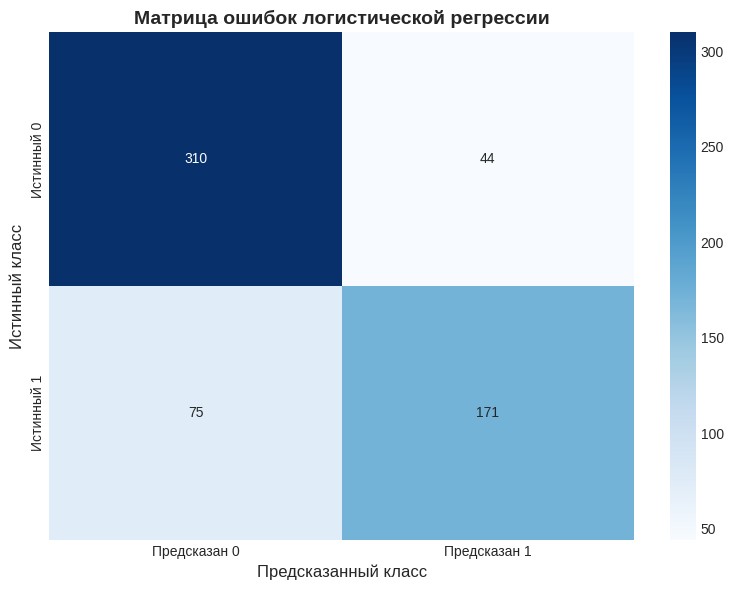


Отчёт по классификации:
                precision    recall  f1-score   support

No Default (0)       0.81      0.88      0.84       354
   Default (1)       0.80      0.70      0.74       246

      accuracy                           0.80       600
     macro avg       0.80      0.79      0.79       600
  weighted avg       0.80      0.80      0.80       600



In [18]:
# ## 9. Оценка лучшей модели на тестовой выборке

# %%
# Предсказания лучшей модели
y_pred_logreg = best_model.predict(X_test)
y_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Вычисляем метрики
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_proba_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("\nМетрики лучшей модели на тестовой выборке:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"ROC-AUC: {roc_auc_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"F1-score: {f1_logreg:.4f}")

# Матрица ошибок
print("\nМатрица ошибок (Confusion Matrix):")
cm = confusion_matrix(y_test, y_pred_logreg)
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предсказан 0', 'Предсказан 1'],
            yticklabels=['Истинный 0', 'Истинный 1'])
plt.title('Матрица ошибок логистической регрессии', fontsize=14, fontweight='bold')
plt.ylabel('Истинный класс', fontsize=12)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.tight_layout()
plt.savefig(figures_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Отчёт по классификации
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred_logreg,
                            target_names=['No Default (0)', 'Default (1)']))

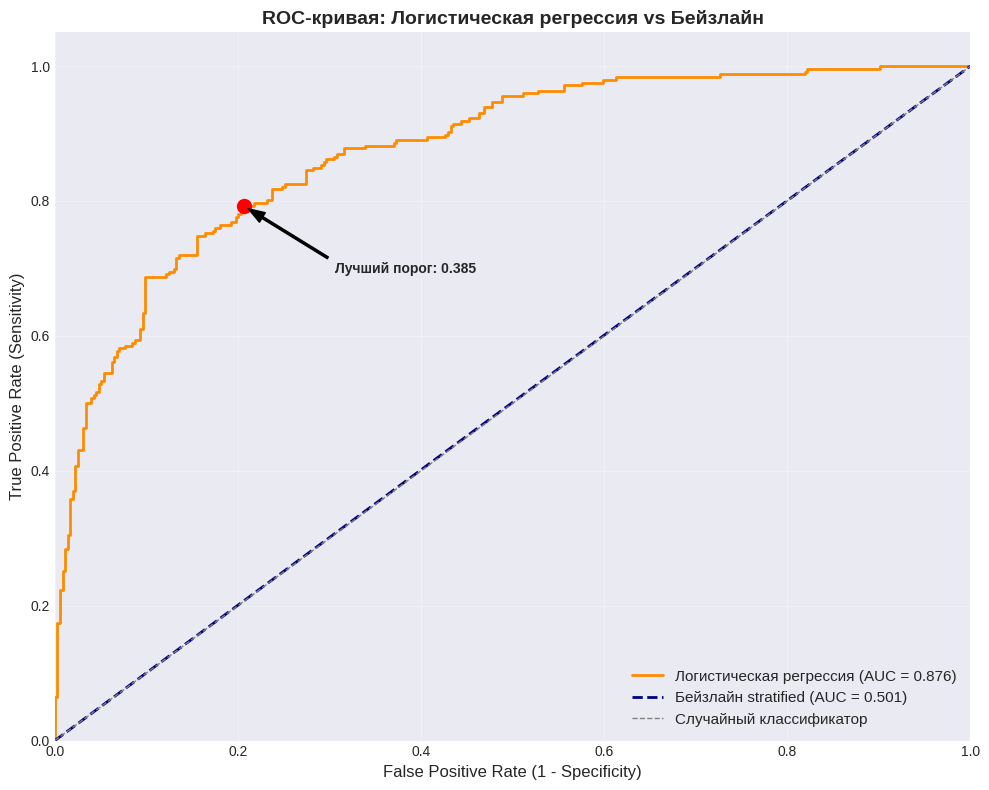


Лучший порог отсечения (по минимальному расстоянию до (0,1)): 0.385


In [19]:
# ## 10. ROC-кривая

# %%
# Вычисляем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)
roc_auc = auc(fpr, tpr)

# ROC-кривая для бейзлайна (stratified)
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_proba_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Строим ROC-кривую
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Логистическая регрессия (AUC = {roc_auc:.3f})')
plt.plot(fpr_dummy, tpr_dummy, color='navy', lw=2, linestyle='--',
         label=f'Бейзлайн stratified (AUC = {roc_auc_dummy:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Случайный классификатор')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC-кривая: Логистическая регрессия vs Бейзлайн', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# Добавляем аннотацию с лучшим порогом (точка с минимальным расстоянием до левого верхнего угла)
distances = np.sqrt((1 - tpr)**2 + fpr**2)
best_idx = np.argmin(distances)
best_threshold = thresholds[best_idx]
plt.plot(fpr[best_idx], tpr[best_idx], 'ro', markersize=10)
plt.annotate(f'Лучший порог: {best_threshold:.3f}',
             xy=(fpr[best_idx], tpr[best_idx]),
             xytext=(fpr[best_idx] + 0.1, tpr[best_idx] - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nЛучший порог отсечения (по минимальному расстоянию до (0,1)): {best_threshold:.3f}")


Результаты кросс-валидации для разных значений C:
 C (регуляризация)  Средний ROC-AUC  Стд. отклонение ROC-AUC
           100.000         0.860663                 0.008987
            10.000         0.860659                 0.008981
             1.000         0.860659                 0.008967
             0.100         0.860605                 0.009034
             0.010         0.860293                 0.009331
             0.001         0.859726                 0.009633


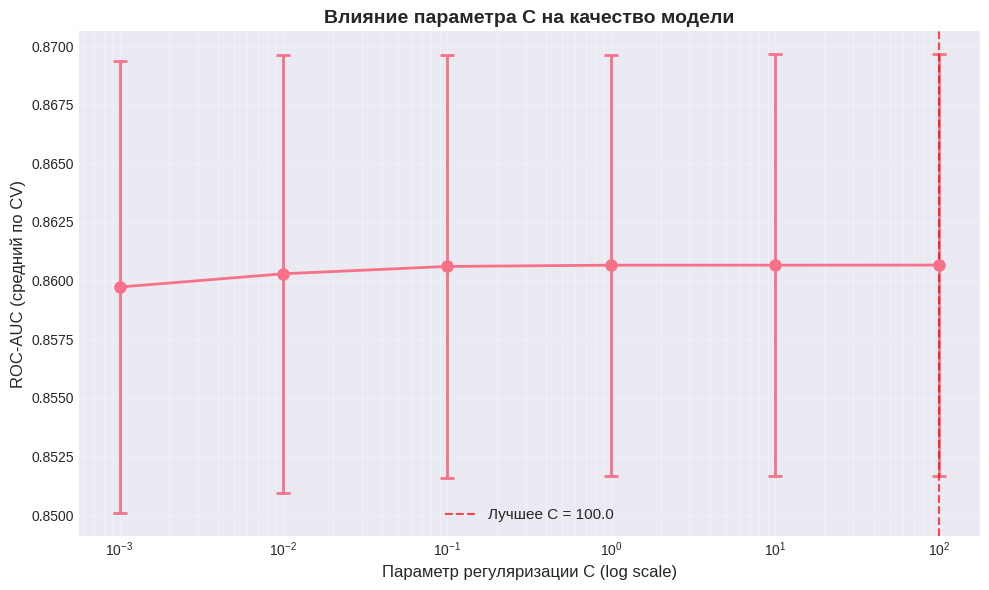

In [20]:
# ## 11. Влияние гиперпараметров на качество модели

# %%
# Извлекаем результаты GridSearchCV для анализа
cv_results = pd.DataFrame(grid_search.cv_results_)

# Выбираем только нужные колонки
cv_results_display = cv_results[['param_logreg__C', 'mean_test_score', 'std_test_score']].copy()
cv_results_display.columns = ['C (регуляризация)', 'Средний ROC-AUC', 'Стд. отклонение ROC-AUC']

print("Результаты кросс-валидации для разных значений C:")
print(cv_results_display.sort_values('Средний ROC-AUC', ascending=False).to_string(index=False))

# Визуализация влияния параметра C на ROC-AUC
plt.figure(figsize=(10, 6))
plt.errorbar(cv_results['param_logreg__C'],
             cv_results['mean_test_score'],
             yerr=cv_results['std_test_score'],
             marker='o', markersize=8, capsize=5, capthick=2,
             linestyle='-', linewidth=2)

plt.xscale('log')
plt.xlabel('Параметр регуляризации C (log scale)', fontsize=12)
plt.ylabel('ROC-AUC (средний по CV)', fontsize=12)
plt.title('Влияние параметра C на качество модели', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')

# Подсвечиваем лучшее значение C
best_C = best_params['logreg__C']
best_score = grid_search.best_score_
plt.axvline(x=best_C, color='red', linestyle='--', alpha=0.7, label=f'Лучшее C = {best_C}')
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig(figures_dir / 'parameter_C_influence.png', dpi=300, bbox_inches='tight')
plt.show()


10 наиболее важных признаков (по абсолютному значению коэффициента):
          Признак  Коэффициент  Абсолютное значение
   debt_to_income     1.160633             1.160633
num_late_payments     0.905598             0.905598
     credit_score    -0.767062             0.767062
region_risk_score     0.742734             0.742734
     active_loans     0.650813             0.650813
     has_car_loan     0.396561             0.396561
     has_mortgage     0.305388             0.305388
 num_credit_cards    -0.086842             0.086842
 checking_balance     0.078863             0.078863
              age     0.065721             0.065721


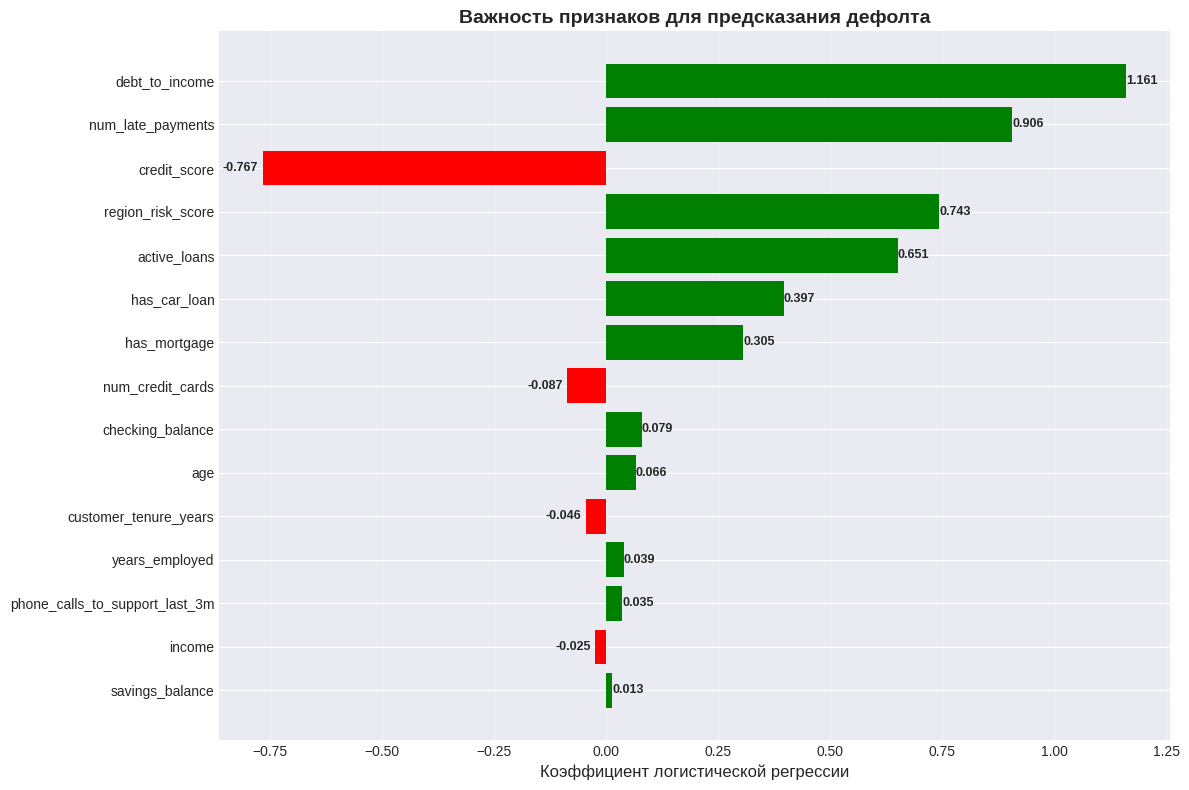

In [21]:
# ## 12. Важность признаков

# %%
# Извлекаем коэффициенты логистической регрессии
logreg_model = best_model.named_steps['logreg']
feature_names = X.columns

# Создаем DataFrame с коэффициентами
coef_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': logreg_model.coef_[0],
    'Абсолютное значение': np.abs(logreg_model.coef_[0])
}).sort_values('Абсолютное значение', ascending=False)

print("10 наиболее важных признаков (по абсолютному значению коэффициента):")
print(coef_df.head(10).to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in coef_df['Коэффициент'].head(15)]
bars = plt.barh(coef_df['Признак'].head(15)[::-1], coef_df['Коэффициент'].head(15)[::-1],
                color=colors[::-1])

plt.xlabel('Коэффициент логистической регрессии', fontsize=12)
plt.title('Важность признаков для предсказания дефолта', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Добавляем аннотации с значениями
for bar in bars:
    width = bar.get_width()
    plt.text(width if width > 0 else width - 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             ha='left' if width > 0 else 'right',
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

СРАВНЕНИЕ МОДЕЛЕЙ

Таблица сравнения метрик на тестовой выборке:
                  Модель  Accuracy  ROC-AUC  Precision   Recall  F1-score
Бейзлайн (most_frequent)  0.590000 0.500758        NaN      NaN       NaN
 Логистическая регрессия  0.801667 0.875649   0.795349 0.695122  0.741866


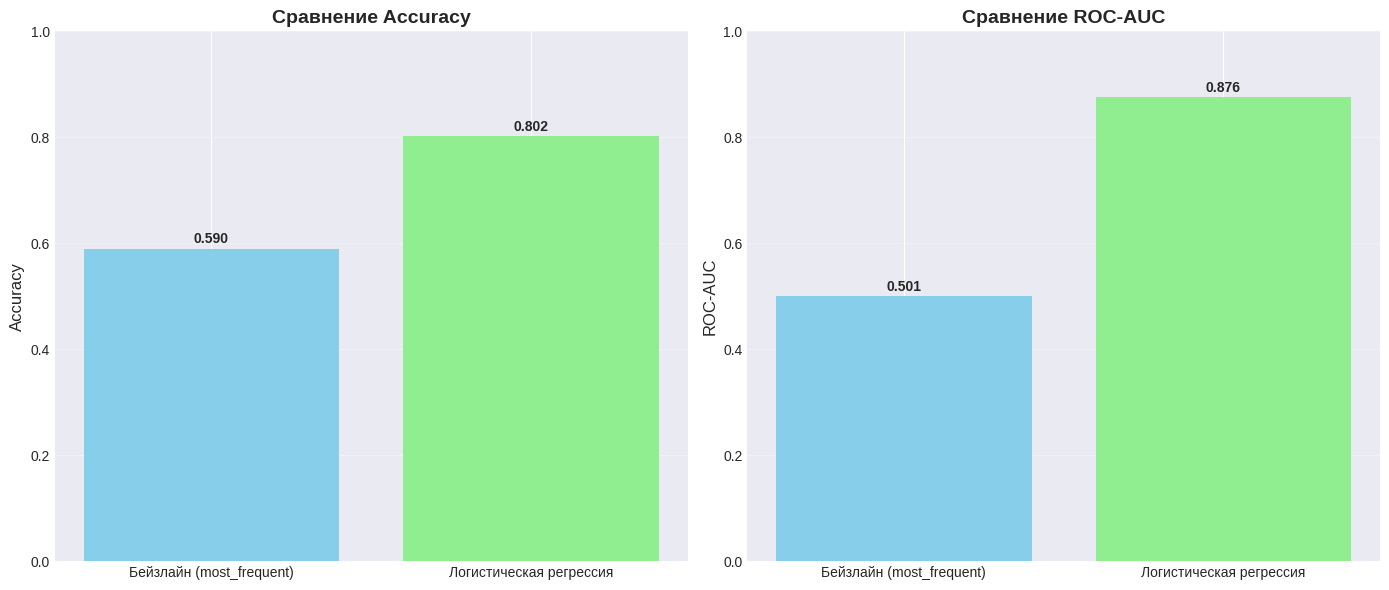

In [22]:
# ## 13. Сравнение моделей

# %%
# Создаем таблицу сравнения моделей
comparison_df = pd.DataFrame({
    'Модель': ['Бейзлайн (most_frequent)', 'Логистическая регрессия'],
    'Accuracy': [accuracy_dummy, accuracy_logreg],
    'ROC-AUC': [roc_auc_dummy, roc_auc_logreg],
    'Precision': [np.nan, precision_logreg],
    'Recall': [np.nan, recall_logreg],
    'F1-score': [np.nan, f1_logreg]
})

print("="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)
print("\nТаблица сравнения метрик на тестовой выборке:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Сравнение Accuracy
axes[0].bar(comparison_df['Модель'], comparison_df['Accuracy'], color=['skyblue', 'lightgreen'])
axes[0].set_title('Сравнение Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for idx, value in enumerate(comparison_df['Accuracy']):
    axes[0].text(idx, value + 0.01, f'{value:.3f}', ha='center', fontweight='bold')

# Сравнение ROC-AUC
axes[1].bar(comparison_df['Модель'], comparison_df['ROC-AUC'], color=['skyblue', 'lightgreen'])
axes[1].set_title('Сравнение ROC-AUC', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for idx, value in enumerate(comparison_df['ROC-AUC']):
    axes[1].text(idx, value + 0.01, f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# ## 14. Текстовый отчёт и выводы

# Создаем директорию для артефактов
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# Сохраняем результаты
comparison_df.to_csv(artifacts_dir / 'models_comparison.csv', index=False)
cv_results_display.to_csv(artifacts_dir / 'grid_search_results.csv', index=False)
coef_df.to_csv(artifacts_dir / 'feature_coefficients.csv', index=False)

print("="*80)
print("ФИНАЛЬНЫЙ ТЕКСТОВЫЙ ОТЧЁТ")
print("="*80)

print(f"""
Эксперимент по прогнозированию дефолта показал следующие результаты.
Бейзлайн-модель (DummyClassifier) достигает accuracy {accuracy_dummy:.3f} и ROC-AUC {roc_auc_dummy:.3f},
что соответствует предсказанию наиболее частого класса.

Логистическая регрессия с оптимальным параметром регуляризации C={best_C}
значительно улучшает обе метрики: accuracy {accuracy_logreg:.3f} (+{accuracy_logreg - accuracy_dummy:.3f})
и ROC-AUC {roc_auc_logreg:.3f} (+{roc_auc_logreg - roc_auc_dummy:.3f}).

ROC-AUC {roc_auc_logreg:.3f} указывает на хорошую разделяющую способность модели.
Наиболее важными признаками оказались {", ".join(coef_df['Признак'].head(3).tolist())}.

Модель демонстрирует практическую полезность для оценки кредитных рисков,
но для производственного использования требует дополнительной валидации
и возможной калибровки вероятностей.
""")

print("\n" + "="*80)
print("ФАЙЛЫ СОХРАНЕНЫ:")
print("="*80)
print(f"- Графики: {figures_dir}/")
print(f"- Артефакты: {artifacts_dir}/")
print(f"- Основной ноутбук: HW05.ipynb")
print("\nЭксперимент успешно завершён!")

ФИНАЛЬНЫЙ ТЕКСТОВЫЙ ОТЧЁТ

Эксперимент по прогнозированию дефолта показал следующие результаты. 
Бейзлайн-модель (DummyClassifier) достигает accuracy 0.590 и ROC-AUC 0.501, 
что соответствует предсказанию наиболее частого класса.

Логистическая регрессия с оптимальным параметром регуляризации C=100.0 
значительно улучшает обе метрики: accuracy 0.802 (+0.212) 
и ROC-AUC 0.876 (+0.375).

ROC-AUC 0.876 указывает на хорошую разделяющую способность модели. 
Наиболее важными признаками оказались debt_to_income, num_late_payments, credit_score.

Модель демонстрирует практическую полезность для оценки кредитных рисков, 
но для производственного использования требует дополнительной валидации 
и возможной калибровки вероятностей.


ФАЙЛЫ СОХРАНЕНЫ:
- Графики: figures/
- Артефакты: artifacts/
- Основной ноутбук: HW05.ipynb

Эксперимент успешно завершён!
